# XGBoost2GPU Example

Este notebook demonstra como usar a classe `XGBoost2GPU` para gerar código CUDA a partir de modelos XGBoost treinados com TreeLUT.

## Importações e Configuração do Ambiente

In [51]:
import sys
import os
from pathlib import Path



# Importações principais
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Minhas importações
from LoadDataset import LoadDataset
from treelut import TreeLUTClassifier
from xgboost2gpu import XGBoost2GPU


## Parâmetros do Modelo

In [ ]:
# Parâmetros para o XGBoost
xgb_params = {
    'objective': 'multi:softmax', 
    'num_class': 2, 
    'n_estimators':3, 
    'max_depth': 3, 
    'eta': 0.8
}

# Parâmetros para o TreeLUT
treelut_params = {
    'w_feature': 2, 
    'w_tree': 3,
    'bits_features': 16,
    'pipeline': [0, 0, 0], 
    'dir_path': './OutputFiles/MakeDataset/',
    'style': 'mux',
    'argmax': True,
    'quantized': True
}

# Parâmetros para o make_classification
make_classification_params = {
    'n_samples': 50000, 
    'n_features': 50, 
    'n_informative': 6, 
    'n_redundant': 30, 
    'n_classes': xgb_params['num_class'], 
    'random_state': 42
}

# Parâmetros para o XGBoost2GPU
xgb2gpu_params = {
    'percentage_to_cut': 0.30,
    'strategy': 'exponential',
    'level_importance': 0.5,
    'progress_importance': 0.7,
    'level_bias': 1.0,
    'max_cut_percentage': 0.2,
    'urgency_override_threshold': 1.5,
    'output_file': 'prune.csv'
}

## Carregamento e Preparação dos Dados

Vamos usar um dataset sintético para demonstração. Em um cenário real, você pode usar qualquer dataset de classificação.

In [53]:
# Gerar dados sintéticos para demonstração
from sklearn.datasets import make_classification

# Criar dataset sintético
X, y = make_classification(**make_classification_params)

# Transformar os dados para inteiros positivos
X = (X * 100000).astype(np.int32)  # Multiplicar por 1000 para evitar valores negativos



# Converter para DataFrame para facilitar manipulação
data = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
target = pd.Series(y, name='target')

# # Load Covtype dataset
# susy = pd.read_csv('../data/SUSY_int.csv')
# data = susy.drop(columns=['target'])
# target = susy['target'].astype('int')



print(f"Dataset shape: {data.shape}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")
print(f"First 5 rows of data:\n{data.head()}")

Dataset shape: (50000, 50)
Classes: [0 1]
Class distribution: [25009 24991]
First 5 rows of data:
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0      -7829       5297     116493      51531    -143760     -61649   
1    -102631     136902    -296637      55099    -105227    -295012   
2       1252    -109779     533384      32418     -18901     457762   
3     -24068     131510      15448     -63011      -3866     576362   
4     -38509      45192    -143675    -148367      22526    -269779   

   feature_6  feature_7  feature_8  feature_9  ...  feature_40  feature_41  \
0    -280763      70185     -43593     -85301  ...      147504     -109126   
1     -32976      63051     -72038    -149832  ...      -11999       26856   
2      51587     -76927       6724     -81287  ...       80642      123181   
3     216117      39282     105944    -280777  ...     -122832       43693   
4    -333565     137554      36078    -171227  ...      315472      -72249   

   fea

In [54]:


# Converter para uint8 para compatibilidade
data_un = data.astype('int32')
data_un = data_un.astype(f'uint{treelut_params["bits_features"]}')


X_train, X_test, y_train, y_test = train_test_split(
    data_un, target, test_size=0.2, random_state=42
)

# Obter valores máximos e mínimos para quantização
max_values = X_test.max().astype(f'uint{treelut_params["bits_features"]}').to_numpy()
min_values = X_test.min().astype(f'uint{treelut_params["bits_features"]}').to_numpy()

print("Valores máximos por feature:")
print(max_values)
print("\nValores mínimos por feature:")
print(min_values)

Valores máximos por feature:
[65532 65533 65520 65533 65529 65531 65533 65534 65533 65528 65534 65527
 65531 65528 65529 65535 65529 65533 65518 65531 65534 65535 65534 65533
 65532 65532 65535 65521 65535 65534 65516 65522 65530 65524 65534 65534
 65534 65532 65527 65521 65528 65509 65525 65520 65532 65529 65521 65519
 65533 65530]

Valores mínimos por feature:
[ 8 12  0  2  2  1  0 14  0  2 11  6  8 10  2 19  6  0  0  0 16  6  2  0
  6  4  1  0  1 22 13 12 12  9  2  0  2  8  6  8  2  3  0 33  5  1  3  6
 15  0]


## Quantização dos Dados

In [55]:
# Aplicar normalização Min-Max
scaler = MinMaxScaler()
w_feature_treelut = treelut_params['w_feature']

X_train_min_max = np.round(scaler.fit_transform(X_train) * (2**w_feature_treelut - 1))
X_test_min_max = np.clip(
    np.round(scaler.transform(X_test) * (2**w_feature_treelut - 1)), 
    0, 2**w_feature_treelut - 1
)

# Quantização simples usando operação bit-wise
X_train_quantized = np.array(X_train, dtype=np.int32) & (2**w_feature_treelut - 1)
X_test_quantized = np.array(X_test, dtype=np.int32) & (2**w_feature_treelut - 1)

print(f"Dados originais shape: {X_train.shape}")
print(f"Dados quantizados shape: {X_train_quantized.shape}")

Dados originais shape: (40000, 50)
Dados quantizados shape: (40000, 50)


## Treinamento do Modelo XGBoost

In [56]:
# Treinar modelo XGBoost com dados quantizados
xgb_clf = XGBClassifier(**xgb_params)
xgb_clf.fit(X_train_quantized, y_train)
y_pred_xgb = xgb_clf.predict(X_test_quantized)
print(f"Acurácia XGBoost (dados quantizados): {accuracy_score(y_pred_xgb, y_test):.3f}")

# Treinar modelo XGBoost com dados originais para comparação
xgb_clf_original = XGBClassifier(**xgb_params)
xgb_clf_original.fit(X_train, y_train)
y_pred_xgb_original = xgb_clf_original.predict(X_test)
print(f"Acurácia XGBoost (dados originais): {accuracy_score(y_pred_xgb_original, y_test):.3f}")

# Treinar modelo XGBoost com dados min-max normalizados
xgb_clf_min_max = XGBClassifier(**xgb_params)
xgb_clf_min_max.fit(X_train_min_max, y_train)
y_pred_xgb_min_max = xgb_clf_min_max.predict(X_test_min_max)
print(f"Acurácia XGBoost (min-max): {accuracy_score(y_pred_xgb_min_max, y_test):.3f}")

Acurácia XGBoost (dados quantizados): 0.499
Acurácia XGBoost (dados originais): 0.493
Acurácia XGBoost (min-max): 0.502


## Conversão para TreeLUT

In [57]:
# Escolher dados de teste baseado nos parâmetros do TreeLUT
treelut_X_test = X_test if treelut_params['quantized'] else X_test_quantized

# Criar e converter modelo TreeLUT
treelut_clf = TreeLUTClassifier(
    xgb_model=xgb_clf_min_max, 
    **treelut_params, 
    min=min_values, 
    max=max_values
)

treelut_clf.convert()
y_pred_treelut = treelut_clf.predict(X_test_min_max)
print(f"Acurácia TreeLUT: {accuracy_score(y_pred_treelut, y_test):.3f}")

# Save verilog
treelut_clf.verilog()
treelut_clf.testbench(treelut_X_test, y_test)

# Mostrar informações sobre as árvores
print(f"\nNúmero de árvores: {len(treelut_clf.trees)}")
print(f"Número total de nós: {sum(treelut_clf.nodes())}")
print(f"Número de nós por árvore: {treelut_clf.nodes()}")
print(f"Número de classes: {treelut_clf.n_classes}")

Acurácia TreeLUT: 0.499

Número de árvores: 6
Número total de nós: 90
Número de nós por árvore: [15, 15, 15, 15, 15, 15]
Número de classes: 2


## Geração de Código CUDA com XGBoost2GPU

In [ ]:
# Criar instância do XGBoost2GPU
xgb2gpu = XGBoost2GPU(treelut_model=treelut_clf, 
                      w_feature=treelut_params['w_feature'],
                      w_tree=treelut_params['w_tree'], 
                      n_samples=X_test.shape[0],
                      n_threads=1,
                      n_blocks=768)

# Definir arquivo de saída
output_file = f"xgboost_cuda_generated.cu"

# Gerar código CUDA
xgb2gpu.generate_cuda_code(output_file)
print(f"✅ Código CUDA gerado com sucesso em: {output_file}")

# Calcular e salvar probabilidades de corte
xgb2gpu.calculate_forest_probabilities(**xgb2gpu_params)
print("✅ Probabilidades de corte calculadas e salvas em prune.csv")


CUDA code generated and saved to xgboost_cuda_generated.cu
✅ Código CUDA gerado com sucesso em: xgboost_cuda_generated.cu


TypeError: XGBoost2GPU.calculate_forest_probabilities() got an unexpected keyword argument 'num_threads'

### Análise de Probabilidades de Corte

In [ ]:
prune_matrix = xgb2gpu.prune_matrix(num_threads=1000, save_matrix=True)
unique_rows, counts = np.unique(prune_matrix, axis=0, return_counts=True)

print(f"Total de amostras: {len(prune_matrix)}")
print(f"Padrões únicos: {len(unique_rows)}")
print(f"Padrões que se repetem: {len(counts[counts > 1])}")
print(f"Maior repetição: {max(counts)}")

# Valor de 0 e 1 de cada linha
print("Valores de 0 e 1 de cada linha:")
num_1s = []
num_0s = []
for row in prune_matrix:
    num_1s.append(np.sum(row))
    num_0s.append(len(row) - np.sum(row))
print(f"Número médio de 1s: {np.mean(num_1s):.3f}")
print(f"Número médio de 0s: {np.mean(num_0s):.3f}")

Prune matrix saved to 'prune_matrix.csv'.
Total de amostras: 1000
Padrões únicos: 1000
Padrões que se repetem: 0
Maior repetição: 1
Valores de 0 e 1 de cada linha:
Número médio de 1s: 26.454
Número médio de 0s: 63.546


In [ ]:
# Salvar X_test em um arquivo CSV
def save_test_data_to_csv(X_test, file_path):
    try:
        # Drop header and index to match the expected format
        if isinstance(X_test, pd.DataFrame):
            X_test = X_test.values  # Convert DataFrame to numpy array if needed
            # Drop header
        elif isinstance(X_test, pd.Series):
            X_test = X_test.values.reshape(-1, 1)  # Convert Series to 2D array
        elif not isinstance(X_test, np.ndarray):
            raise ValueError("X_test deve ser um DataFrame ou um numpy array.")
        # Save to CSV
        df = pd.DataFrame(X_test)
        df.to_csv(file_path, index=False, header=False)
        print(f"✅ Dados de teste salvos em: {file_path}")
    except Exception as e:
        print(f"❌ Erro ao salvar os dados de teste: {e}")
save_test_data_to_csv(X_test, "input.csv")
save_test_data_to_csv(y_test, "expected_output.csv")

✅ Dados de teste salvos em: input.csv
✅ Dados de teste salvos em: expected_output.csv


## Próximos Passos

Para usar o código CUDA gerado:

1. **Compilação**: Compile o arquivo `.cu` usando `nvcc`
2. **Dados de entrada**: Prepare arquivos CSV com os dados de teste:
   - `input.csv`: Dados de entrada para inferência
   - `expected_output.csv`: Rótulos esperados para validação
   - `prune.csv`: Vetor de poda para controlar quais nós usar
3. **Execução**: Execute o programa CUDA compilado
4. **Análise**: Verifique a acurácia e performance

### Exemplo de compilação:
```bash
nvcc -o xgboost_gpu xgboost_cuda_generated.cu
./xgboost_gpu
```

### Visualização de Importâncias

Plotando 3 árvores por classe, para 2 classes.


/tmp/ipykernel_284947/3519848543.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('tab10')


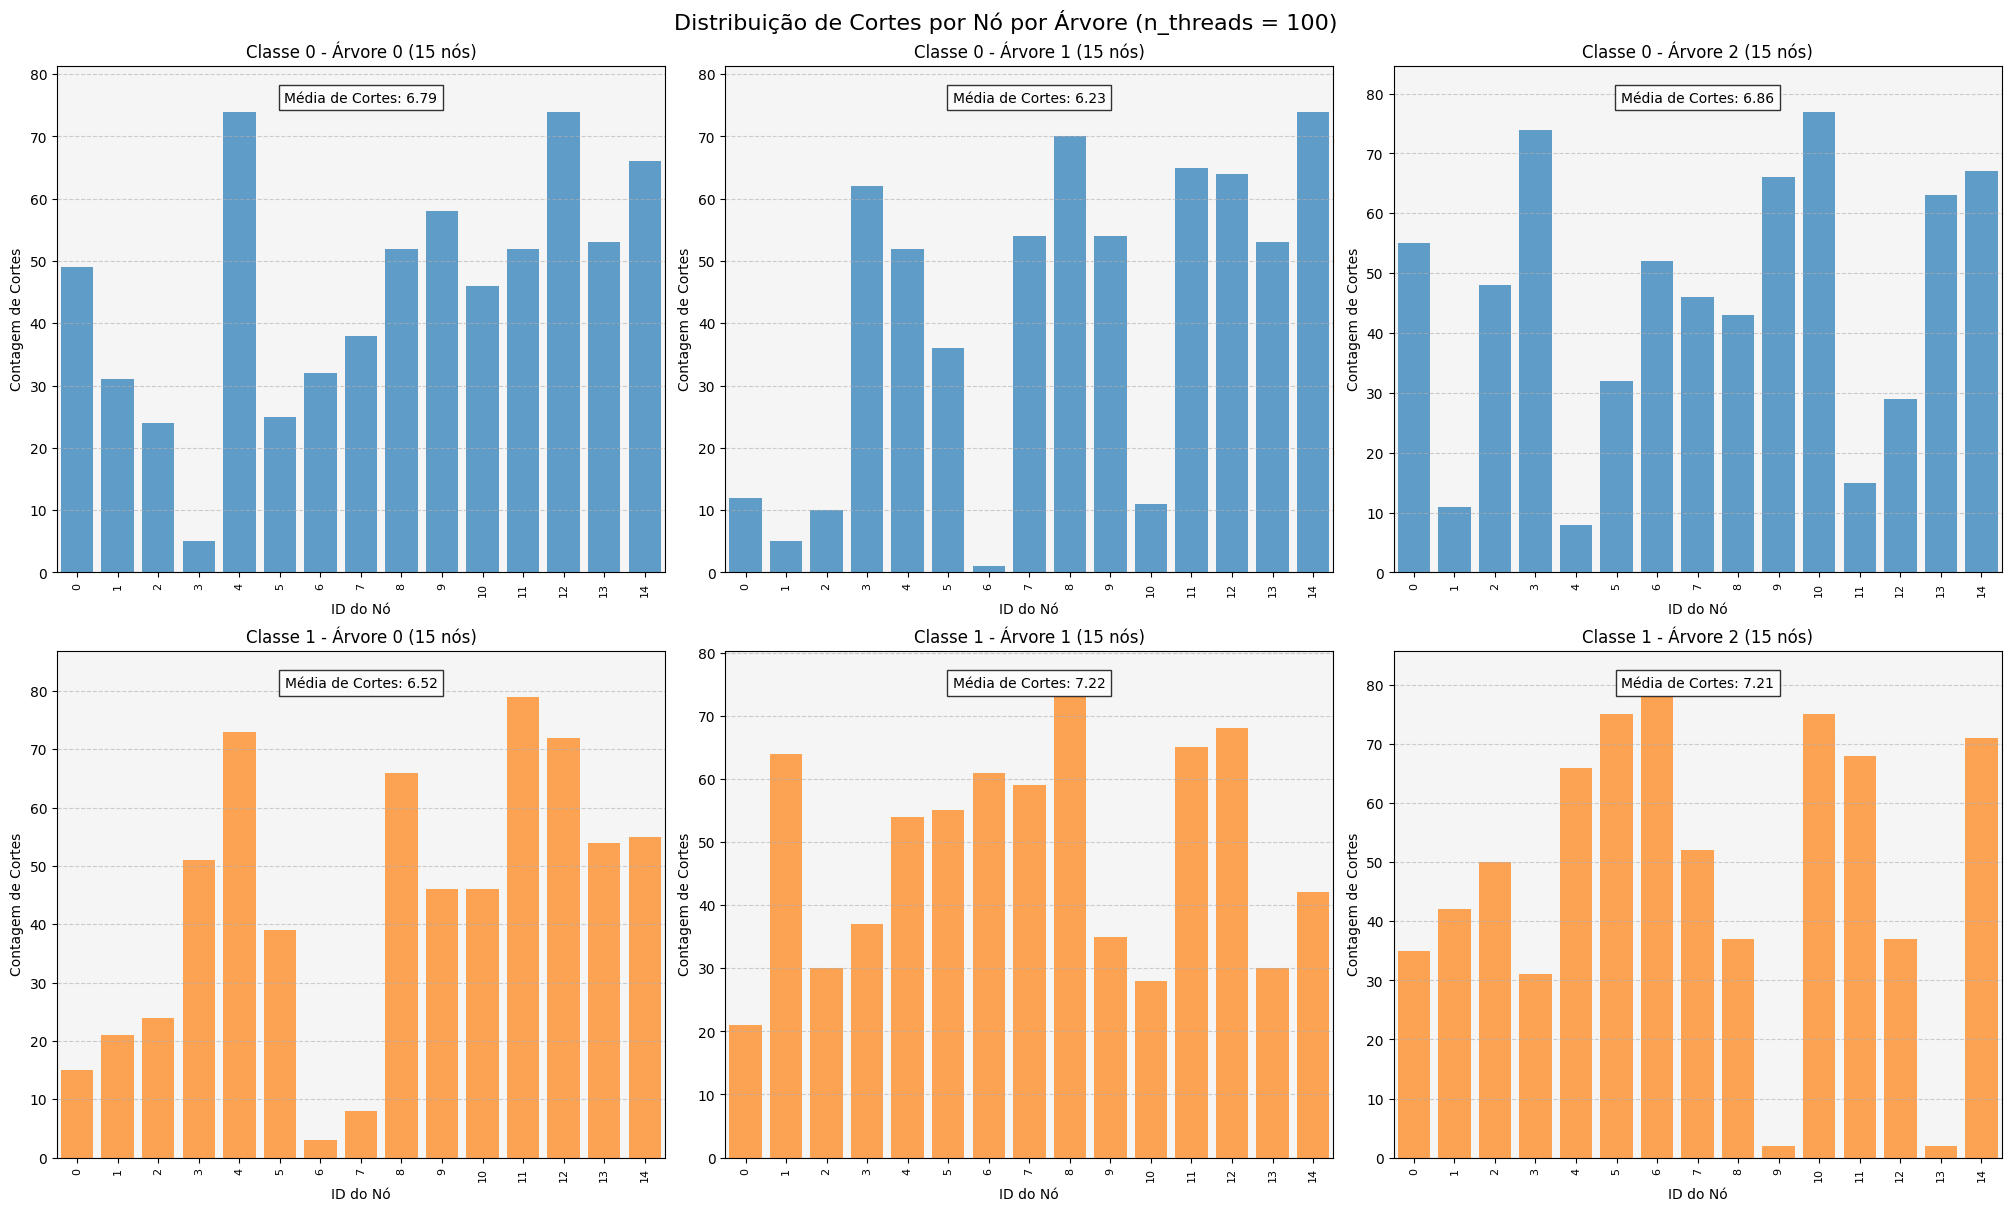

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

def save_trees_to_file(trees, filename='trees.txt'):
    with open(filename, 'w') as f:
        f.write(str(trees))
    print(f"Árvores salvas em {filename}")

def plot_tree_cut_distribution(trees, num_threads=1000, num_classes=3, num_trees_per_class=4):
    """
    Plota a distribuição de cortes dos nós para um conjunto de árvores,
    com as classes nas linhas e as árvores nas colunas.
    """
    if not trees:
        print("Nenhuma árvore para plotar.")
        return

    # Configuração do layout dos subplots (CLASSES x ÁRVORES)
    fig, axes = plt.subplots(
                            nrows=num_classes,
                            ncols=num_trees_per_class,
                            figsize=(20, 12),
                            squeeze=False,
                            constrained_layout=True)

    print(f"Plotando {num_trees_per_class} árvores por classe, para {num_classes} classes.")
    fig.suptitle(f'Distribuição de Cortes por Nó por Árvore (n_threads = {num_threads})', fontsize=16)

    # Paleta de cores por classe
    cmap = get_cmap('tab10')
    class_colors = [cmap(i) for i in range(num_classes)]

    # Loop principal para plotar cada árvore em sua posição correta na grade
    for class_idx in range(num_classes):
        for tree_idx in range(num_trees_per_class):
            # Calcula o índice da árvore na lista de dados
            # (Ex: Árvore 0 da Classe 1 -> 1 + 0*3 = índice 1)
            # (Ex: Árvore 1 da Classe 0 -> 0 + 1*3 = índice 3)
            list_key = class_idx + tree_idx * num_classes
            
            # Pega o subplot correspondente
            ax = axes[class_idx, tree_idx]

            # Verifica se a árvore existe nos dados carregados
            if list_key >= len(trees):
                ax.set_title(f'Classe {class_idx} - Árvore {tree_idx} (Ausente)')
                ax.axis('off')
                continue

            tree = trees[list_key]

            # Prepara dados para plotagem
            nodes = sorted(tree.keys())
            cut_counts = simulate_cuts(tree, num_threads)
            total_cuts_mean = sum(cut_counts.values()) / num_threads if num_threads > 0 else 0

            # Plotagem das barras
            ax.bar(nodes, [cut_counts.get(node, 0) for node in nodes],
                   color=class_colors[class_idx], alpha=0.7)

            # Customização do gráfico
            ax.set_title(f'Classe {class_idx} - Árvore {tree_idx} ({len(nodes)} nós)')
            ax.set_xlabel('ID do Nó')
            ax.set_ylabel('Contagem de Cortes')
            if nodes:
                ax.set_xticks(nodes)
                ax.tick_params(axis='x', rotation=90, labelsize=8) # Rotaciona para melhor visualização
                ax.set_xlim(min(nodes) - 0.5, max(nodes) + 0.5)

            # Adiciona rótulo com a média de cortes
            total_cuts_label = f'Média de Cortes: {total_cuts_mean:.2f}'
            ax.text(0.5, 0.95, total_cuts_label, transform=ax.transAxes,
                    fontsize=10, ha='center', va='top', bbox=dict(facecolor='white', alpha=0.8))

            ax.set_ylim(0, max(cut_counts.values()) * 1.1 if cut_counts else 1)
            ax.set_facecolor('whitesmoke')
            ax.grid(axis='y', linestyle='--', alpha=0.6)

    plt.show()

def simulate_cuts(tree, num_threads):
    """
    Função de simulação para gerar contagens de cortes aleatórias para cada nó.
    """
    cut_counts = {node: 0 for node in tree.keys()}
    for node in tree.keys():
        # Gera um valor aleatório para simular a contagem de cortes
        cut_counts[node] = np.random.randint(0, num_threads * 0.8)
    return cut_counts

trees_data = xgb2gpu.model.trees
plot_tree_cut_distribution(trees_data, num_threads=100, 
                           num_classes=xgb_params['num_class'], 
                           num_trees_per_class=xgb_params['n_estimators'])

0
90


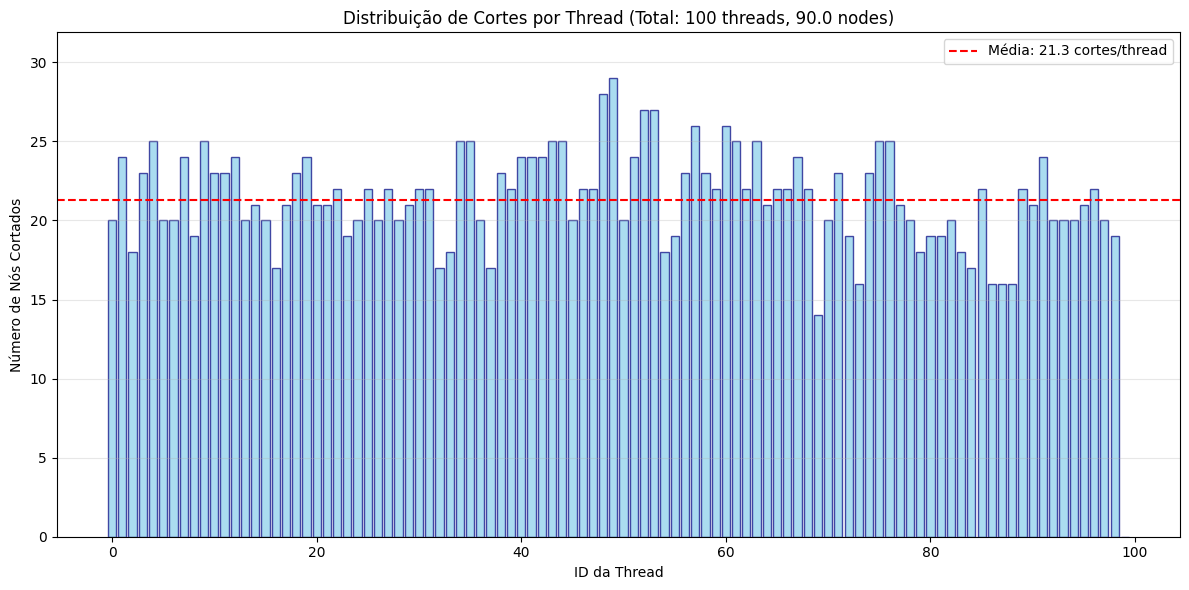

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_cuts_per_thread(trees, num_threads=1000, num_classes=3):
    # Dicionário para armazenar cortes por thread
    thread_cuts = defaultdict(int)
    num_nodes = defaultdict(int)

    # Simulação: para cada thread, conta quantos nós foram cortados
    for thread_id in range(num_threads):
        if thread_id == 0: continue
        for tree in trees:
            for node, value in tree.items():
                if xgb2gpu.should_cut_node(thread_id, value['global_id']):
                    thread_cuts[thread_id] += 1
                num_nodes[thread_id] += 1

    print(thread_cuts[0])
    print(num_nodes[1])

    mean_nodes = np.mean(list(num_nodes.values())) if num_nodes else 0

    # Prepara dados para plotagem
    cuts_count = [count for count in thread_cuts.values()]
    threads = range(num_threads)
    
    # Configuração do plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(threads, cuts_count, color='skyblue', edgecolor='navy', alpha=0.7)
    
    # Linha de média
    mean_cuts = np.mean(cuts_count)
    plt.axhline(mean_cuts, color='red', linestyle='--', 
                label=f'Média: {mean_cuts:.1f} cortes/thread')
    
    # Customização
    plt.title(f'Distribuição de Cortes por Thread (Total: {num_threads} threads, {mean_nodes:.1f} nodes)')
    plt.xlabel('ID da Thread')
    plt.ylabel('Número de Nós Cortados')
    plt.grid(axis='y', alpha=0.3)
    plt.legend()
    
    # Ajusta eixos para melhor visualização
    max_cuts = max(cuts_count) if cuts_count else 0
    plt.ylim(0, max_cuts * 1.1)
    
    plt.tight_layout()
    plt.show()

trees_data = xgb2gpu.model.trees

plot_cuts_per_thread(trees_data, num_threads=100, num_classes=xgb_params['num_class'])


### Rodar cuda

In [ ]:
! nvcc -arch=sm_89 -O3 -lineinfo -o xgboost_cuda_generated xgboost_cuda_generated.cu -O3 -Wno-deprecated-gpu-targets

In [ ]:
! ./xgboost_cuda_generated


CUDA error: invalid argument
